# Case Study: Cosmogenic production in a setting of a surface that steady uplifts
Authors: Sebastien Lenard
Date: 2022, June.

**NB : cosmogenic is not unit agnostic !!!!**

## Background and Motivation
Cosmogenic nuclides 
Landscape evolution model

reuse of PriorityFlood_LandscapeEvolutionModel notebook

Hypothesis: all sediment is evacuated out of the landscape.

We can't use the PriorityFloodFlowRouter with HexModelGrid
FlowDirectorD8 not implemented for HexModelGrid

Combining uplift function with FlowAccumulator (and DepressionFinderAndRouter) and SPACE Stream Power with Alluvium Conservation and Entrainment, more precisely SpaceLargeScaleEroder (is there really the need?)

space notebook Shobe 2017 and space large scale : https://jupyter.openearthscape.org/hub/user-redirect/lab/tree/landlab-2.4.1/notebooks/tutorials/landscape_evolution/space
Space : bedrock incision (proportional to stream power, stream power law) and sediment transport
https://landlab.readthedocs.io/en/latest/reference/components/space.html?highlight=space%20large#landlab.components.space.space_large_scale_eroder.SpaceLargeScaleEroder

diffusion of hillslope topography and incision of bedrock in fluvial channels

TransportLengthHillslopeDiffuser
https://jupyter.openearthscape.org/hub/user-redirect/lab/tree/landlab-2.4.1/notebooks/tutorials/hillslope_geomorphology/transport-length_hillslope_diffuser/TLHDiff_tutorial.ipynb
this diffuser inspired by Carretier et al., 2016 (and Davy & Lague, 2009)
simplification made by simple linear diffusion models is that the entire landscape is made of the same material. Supposed: sediment.
PB : limitations to soil-mantle hillslopes ? (NB: behaviour different than the lineardiffuser)

Uplift the core compared to base-level boundary nodes

Why the same spatial resolution is used for discretization of hillslope processes and incision by rivers?

Steady state of landscape reached when sediment flux and relief approach an equilibrium (they can't go higher)

IF no diffusion: landscape directly carved in bedrock or very thin regolith



### Table of Contents
1. Initialize and run the component the simplest way.


We start to import all libraries required by this tutorial.

In [30]:
# Libraries for scientific computing (ndarrays) and plotting
import numpy as np
import matplotlib as mpl; import matplotlib.pyplot as plt
from tqdm import tqdm # progress bar
import time # performance testing

# Landlab libraries/methods

from landlab import RasterModelGrid, HexModelGrid, RadialModelGrid, VoronoiDelaunayGrid, NetworkModelGrid # Component to manage the grid

from landlab.components import StreamPowerEroder, SpaceLargeScaleEroder
# import landlab plotting functionality
from landlab import imshowhs_grid, imshow_grid # methods for display
from landlab.plot.drainage_plot import drainage_plot

from landlab.components import FlowRouter, PriorityFloodFlowRouter # TODO>>>>>>>>>>>>> REMOVE PRIORITY


from landlab.components import ThresholdEroder # allows chop-off of slopes above critical gradient (simplistic landslider)
from landlab.components import CosmogenicProductionScaler, CosmogenicProducerInBedrock # cosmogenic nuclide calculations

In [18]:
# Doesn't work on HexModelGrid !!!
# create a plotting routine to make a 3d plot of our surface.
def surf_plot(mg, surface="topographic__elevation", title="Surface plot of topography"):

    fig = plt.figure()
    ax = fig.gca(projection="3d")

    # Plot the surface.
    Z = mg.at_node[surface].reshape(mg.shape)
    color = cm.gray((Z - Z.min()) / (Z.max() - Z.min()))
    surf = ax.plot_surface(
        mg.x_of_node.reshape(mg.shape),
        mg.y_of_node.reshape(mg.shape),
        Z,
        rstride=1,
        cstride=1,
        facecolors=color,
        linewidth=0.0,
        antialiased=False,
    )
    ax.view_init(elev=35, azim=-120)
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Elevation")
    plt.title(title)
    plt.show()
# surf_plot(myGrid, title="Grid 1")

## 1. Initialize the model.

### 1.1 Setting up the model grid.
Create the grid. We use a hexagonal grid to make the case study easier to implement. For the hexagonal grid, giver-receiver distances are homogeneous while for the raster grid distances are heterogeneous because flow can pass through diagonals.

Randomized micro-scale topographic roughness is added to the model grid. While not strictly necessary for the SPACE model to run, the micro-roughness allows flow convergence, channelization, and the development of realistic landscapes.

Zero sediment or soil

All boundaries are let open.

In [181]:
# 1. Grid generation
# 1.1. Parameters
####################
n = 9 #200
xy_spacing = (30, 30)

# LEM
denudation_rate_bedrock_mm_y = 1.e-9 # in mm/y

# Run
dt = 1000 #300 #500 #1000 #250 # timestep in y
n_dt = 1000 #10000 #200 #200 # number of timesteps

# figures
dpi=100
font_size = 10

# Other parameters
random_generator = np.random.Generator(np.random.PCG64(500)) # set constant random seed for "stable" random pull 
                                                             # for VoronoiDelaunayGrid and initial elevation

# Type of grid
model_grid = (RasterModelGrid, HexModelGrid, RadialModelGrid, VoronoiDelaunayGrid, NetworkModelGrid)[0]

if model_grid == VoronoiDelaunayGrid:
    dspacing_max = 0.25 * 30
    from landlab.graph.hex.hex import HorizontalRectTriGraphCython
    x, y = HorizontalRectTriGraphCython.xy_of_node(shape=(n, n), spacing=xy_spacing[0])
    nodes_n = n * n
    dspacing = random_generator.random(nodes_n * 2) * dspacing_max * 2 - dspacing_max
    X = x + dspacing[:nodes_n]
    Y = y + dspacing[nodes_n:]
else:
    X = np.ones(n * n)
    Y = np.ones(n * n)
    
grid_param = {RasterModelGrid: {"shape": (n, n), #2.5 * n
                                "xy_spacing": xy_spacing,
                                "xy_axis_units": "m"},
              HexModelGrid: {"shape": [(2 * n - 1, n), (n, n)][1],
                            "spacing": xy_spacing[0],
                            "node_layout": ["hex", "rect"][1],
                            "xy_axis_units": "m"},
              RadialModelGrid: {"n_rings": n,
                               "nodes_in_first_ring": 5,
                               "spacing": xy_spacing[0],
                               "xy_axis_units": "m"},
              VoronoiDelaunayGrid: {"x": X, #50
                                    "y": Y, 
                                    #"x": np.random.rand(n * 6) * n * xy_spacing[0], #50
                                    #"y": np.random.rand(n * 6) * n * xy_spacing[0], 
                                    "xy_axis_units": "m"},
              NetworkModelGrid: {"yx_of_node": ((0, 100, 200, 200, 300, 400, 400, 125),
                                               (0, 0, 100, -50, -100, 50, -150, -100)),
                                 "links": ((1, 0), (2, 1), (1, 7), (3, 1), (3, 4), (4, 5), (4, 6)),
                                 "xy_axis_units": "m"}
             }[model_grid]


closed_nodes = ["one", "all except one"][1] # closed boundaries

random_topography = 0.0001 # range in elevation (from 0)

# Parameters of the landscape evolution components
param = {FlowRouter: \
             {},
         ThresholdEroder: \
             {"slope_crit": np.tan(35 * np.pi / 180)},
         StreamPowerEroder: \
             {"n_sp": 2,
              "m_sp": 1,
              "K_sp": 1e-9, # 1e-9,
              "discharge_field": ["drainage_area", "water__unit_flux_in"][0],
              "erode_flooded_nodes": False},
         SpaceLargeScaleEroder: \
             {"K_sed": 1e-5,
                "K_br": 1e-5,
                "F_f": 0.0, # 1.0: all sediment exported out of the grid. (soil__depth = 0) : PB: sediment fluxes become null!
                "phi": 0.0,
                "H_star": 1.0,
                "v_s": 5.0,
                "m_sp": 1.,
                "n_sp": 2.,
                "sp_crit_sed": 0,
                "sp_crit_br": 0},
         CosmogenicProductionScaler: \
             {"path_prefix": {"config": "", "data": ""}
             },
         CosmogenicProducerInBedrock: \
             {"system": {"nuclide":"Be10", "mineral": "quartz"},
             "init_condition": {"steady_state_cosmogenic_production":True},
             "path_prefix": {"config": "", "data": ""}}
        }

# Array to save sediment flux, relief values, and average concentrations
sediment_flux_over_time = np.zeros(n_dt + 1) # in m^3/y 
relief_over_time = np.zeros(n_dt + 1) # in m
cosmogenic_concentration_over_time = np.zeros(n_dt + 1) # in atom/g, average over the grid

# 1.2. Grid instantiation and boundaries
########################################

myGrid = model_grid(**grid_param)
nodes_n = myGrid.number_of_nodes
boundary_nodes = myGrid.boundary_nodes

#uplift_rate = 0.001 # uplift rate in m/y
x = myGrid.x_of_node
summit_x = round(n / 3)
uplift_rate = (
    if x <= summit_x:
        x / summit_x * 0.001
    else
        (n - summit_x) * 0.001

# Closed or open boundaries
#if model_grid != NetworkModelGrid
"""one_node = myGrid.boundary_nodes[np.random.randint(len(myGrid.boundary_nodes))]
if closed_nodes == "one":
    myGrid.status_at_node[one_node] = myGrid.BC_NODE_IS_CLOSED
else:
    myGrid.status_at_node[myGrid.boundary_nodes] = myGrid.BC_NODE_IS_CLOSED
    myGrid.status_at_node[one_node] = myGrid.BC_NODE_IS_FIXED_VALUE"""

# 1.3. Topographic elevation
############################
if model_grid == NetworkModelGrid:
    myGrid.at_node["topographic__elevation"] = [0.0, 0.08, 0.25, 0.15, 0.25, 0.4, 0.8, 0.8]
    myGrid.add_field("cell_area_at_node", np.full(shape=nodes_n, fill_value=1.0), at="node")
else:
    # add topographic roughness
    random_noise = random_topography = random_generator.random(nodes_n)  # impose topography values on model grid
    z = myGrid.add_field("topographic__elevation", random_noise, at="node")
    z[boundary_nodes] = 0 # all boundary nodes as base-level
    #z[12] = 0.5
    """z[:] = np.array([5,2,1,4,1,
    1,4,2,5,2,
    2,1,2,1,3,
    1,3,4,1,4,
    3,1,2,2,3]
    )"""

# 1.4. Other fields
###################
myGrid.add_field('denudation_rate_bedrock_mm_y', denudation_rate_bedrock_mm_y * np.ones(myGrid.number_of_nodes))
s = myGrid.add_zeros("soil__depth", at="node", dtype=float)
br =myGrid.add_field("bedrock__elevation", z + s, at="node", dtype=float, copy=True)

# 1.5 Display
#############
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : font_size}
mpl.rc('font', **font)

# 1.5. Grid display
###################
show_elements = True if nodes_n < 50 else False
if model_grid != NetworkModelGrid and 1 != 1: # imshow_grid doesn't work for NetworkModelGrid
    #imshow_grid(myGrid, myGrid.nodes, cmap ="terrain",
    #            grid_units=("m", "m"), var_name="Node id", show_elements=show_elements) #, show_elements=True)
    #plt.show()
    imshow_grid(myGrid, 'topographic__elevation', cmap ="terrain",
                grid_units=("m", "m"), var_name="Elevation (m)", show_elements=show_elements,
               limits=(0, 10)) #, show_elements=True)
    plt.show()

#from landlab.plot import graph
#if n < 11: graph.plot_graph(myGrid, at="node,link")

We then may add the fields to the grid which can be used by the component. 

In [2]:
#s = myGrid.add_zeros("soil__depth", at="node", dtype=float, clobber=True)
#br =myGrid.add_field("bedrock__elevation", z + s, at="node", dtype=float, clobber=True, copy=True)
''

''

# Instanciation of the components that carry out landscape evolution.

Hypothesis: we start from steady state flat landscape, eroding close to zero. The component automatically generate steady state concentrations.

In [182]:
# 2. Instanciations of the landscape evolution model and cosmogenic production
##############################################################################
router = FlowRouter(myGrid, **param[FlowRouter])
#router = PriorityFloodFlowRouter(myGrid)
landslider = ThresholdEroder(myGrid, **param[ThresholdEroder])
inciser = SpaceLargeScaleEroder(myGrid, **param[SpaceLargeScaleEroder])
#inciser = StreamPowerEroder(myGrid, **param[StreamPowerEroder])

cosmo_scaler = CosmogenicProductionScaler(myGrid, **param[CosmogenicProductionScaler])
cosmo_scaler.prepare_first_run()
cosmo_scaler.run_one_step(dt)
cosmo_producer = CosmogenicProducerInBedrock(myGrid, **param[CosmogenicProducerInBedrock])
cosmo_producer.prepare_first_run(cosmo_scaler)
myGrid.add_field("thickness_cover_m", np.zeros(nodes_n), at="node", clobber=True) # TO REMOVE AFTER CLEANING OF CLASS COSMO PRODUCER

sediment_flux_over_time[0] = 0
relief_over_time[0] = np.max(z) - np.min(z)
cosmogenic_concentration_over_time[0] = np.mean(myGrid.at_node["concentration_Be10_quartz_top_bedrock_atom_g"])

In [ ]:
if model_grid != NetworkModelGrid and 1 == 1: # imshow_grid doesn't work for NetworkModelGrid
    show_elements = True if nodes_n < 50 else False
    #imshow_grid(myGrid, myGrid.nodes, cmap ="terrain",
    #            grid_units=("m", "m"), var_name="Node id", show_elements=show_elements) #, show_elements=True)
    #plt.show()
    imshow_grid(myGrid, 'topographic__elevation', cmap ="terrain",
                grid_units=("m", "m"), var_name="Elevation (m)", show_elements=show_elements) #, show_elements=True)
    plt.show()
    imshow_grid(myGrid, 'concentration_Be10_quartz_top_bedrock_atom_g', cmap ="terrain",
                grid_units=("m", "m"), var_name="concentration Be10 quartz (atom/g)", show_elements=show_elements) #, show_elements=True)
    plt.show()
    imshow_grid(myGrid, 'denudation_rate_bedrock_mm_y', cmap ="terrain",
                    grid_units=("m", "m"), var_name="denudation rate bedrock (mm/y)", show_elements=show_elements) #, show_elements=True)
    plt.show()

In [ ]:
#myGrid.at_node.dataset

In [116]:
z[myGrid.core_nodes] += uplift_rate * dt


In [ ]:
mg = RasterModelGrid((5, 5))
mg.set_closed_boundaries_at_grid_edges(False, False, False, False)
z = np.array(
    [
        [0., 0., 0., 0., 0.]
       + [0., 1., 1., 1., 0.]
       + [0., 1., 10., 1., 0.]
        + [0., 1., 1., 1., 0.]
       + [0., 0., 0., 0., 0.]
    ]
)
z = mg.add_field("topographic__elevation", z, at="node")
imshow_grid(mg, 'topographic__elevation', cmap ="terrain",
                grid_units=("m", "m"), var_name="Elevation (m)", show_elements=show_elements,
                limits=(0, 10))
plt.show()

In [107]:
#mg = myGrid
z[mg.core_nodes] += 0.001 * dt
fdir = FlowRouter(mg)
th_ero = ThresholdEroder(mg, slope_crit=0.6)
for t in range(2):
    fdir.run_flow_directions()
    fdir.run_flow_accumulations()
    th_ero.run_one_step()

In [ ]:
imshow_grid(mg, 'topographic__elevation', cmap ="terrain",
                grid_units=("m", "m"), var_name="Elevation (m)", show_elements=show_elements,
                limits=(0, 10))
plt.show()

In [183]:
# 3. First Run
##############
# Uplift
z[myGrid.core_nodes] += uplift_rate * dt
z_old = myGrid.at_node["topographic__elevation"].copy()

t0 = time.time()
router.run_flow_directions()
#print(time.time() - t0)
t0 = time.time()
router.run_flow_accumulations()
#print(time.time() - t0)
t0 = time.time()
landslider.run_one_step();
#print(time.time() - t0)
t0 = time.time()
inciser.run_one_step(dt); 
#print(time.time() - t0)

z_new = myGrid.at_node["topographic__elevation"]
z_diff = z_old - z_new

denudation_rate_bedrock_new = np.vectorize(lambda x:max(x, 1.e-9))(z_diff) / dt * 1e3
myGrid.at_node["denudation_rate_bedrock_mm_y"] = denudation_rate_bedrock_new

#myGrid.at_node["denudation_rate_bedrock_mm_y"][:]= 5000 / dt
t0 = time.time()
cosmo_scaler.run_one_step(dt)
#print(time.time() - t0)
t0 = time.time()
cosmo_producer.run_one_step(dt)
#print(time.time() - t0)

sediment_flux_over_time[1] = np.sum(z_diff[myGrid.core_nodes] * myGrid.area_of_cell) / dt
relief_over_time[1] = np.max(z_new) - np.min(z_new)
cosmogenic_concentration_over_time[1] = np.mean(myGrid.at_node["concentration_Be10_quartz_top_bedrock_atom_g"])

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.44214554  0.89695158
  0.5570242   0.52864422  0.27598204  0.87486219  0.25919925  0.
  0.          0.43132051  0.34973219  0.51601699  0.36904262  0.47215378
  0.19359948  0.24961119  0.          0.          0.48779288  0.63942244
  0.9379636   0.82956436  0.63588529  0.61180013  0.94148359  0.
  0.          0.49529855  0.84738928  0.86683819  0.277924    0.09241115
  0.39955667  0.31962044  0.          0.          0.82113404  0.6514878
  0.10257211  0.33304829  0.46878042  0.94367454  0.10349548  0.
  0.          0.20650179  0.56293664  0.94464691  0.49371532  0.05726163
  0.73371816  0.02202677  0.          0.          0.23133586  0.85003039
  0.79186458  0.11007164  0.50260693  0.09372805  0.12160004  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
[ 0.          0.          0.          0.          0.          

In [176]:
sediment_flux_over_time[1]

0.0

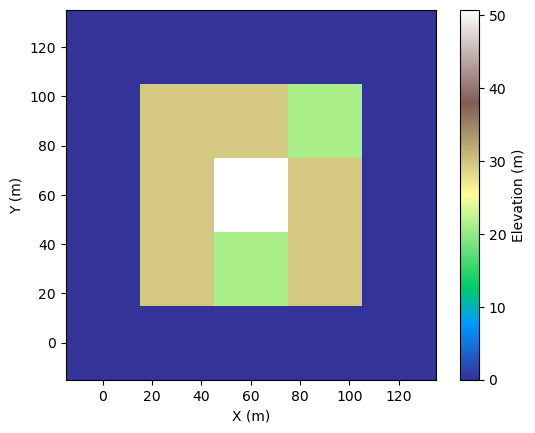

In [149]:
imshow_grid(myGrid, 'topographic__elevation', cmap ="terrain",
                grid_units=("m", "m"), var_name="Elevation (m)", show_elements=show_elements,
           )#limits=(0, 100)) #, show_elements=True)
plt.show()

In [184]:
#run
z = myGrid.at_node["topographic__elevation"]
t0 = time.time()

for i in tqdm(range(2, n_dt)): # 2 and not 0, because 0 is initial situation and we already have a 1st run
   # Uplift
    z[myGrid.core_nodes] += uplift_rate * dt
    z_old = myGrid.at_node["topographic__elevation"].copy()

    router.run_one_step()
    landslider.run_one_step()
    inciser.run_one_step(dt)

    z_new = myGrid.at_node["topographic__elevation"]
    z_diff = z_old - z_new

    denudation_rate_bedrock_new = np.vectorize(lambda x:max(x, 1.e-9))(z_diff) / dt * 1e3
    myGrid.at_node["denudation_rate_bedrock_mm_y"] = denudation_rate_bedrock_new

    #myGrid.at_node["denudation_rate_bedrock_mm_y"][:]= 5000 / dt
    cosmo_scaler.run_one_step(dt)
    cosmo_producer.run_one_step(dt)

    sediment_flux_over_time[i] = np.sum(z_diff[myGrid.core_nodes] * myGrid.area_of_cell) / dt
    relief_over_time[i] = np.max(z_new) - np.min(z_new)
    cosmogenic_concentration_over_time[i] = np.mean(myGrid.at_node["concentration_Be10_quartz_top_bedrock_atom_g"])
    
print(time.time() - t0)
# STRANGE BEHAVIOUS for sediment__influx and sediment__outflux, sediment_influx cannot be mapped with imshow_grid

100%|██████████| 998/998 [00:02<00:00, 334.19it/s]

2.988858938217163


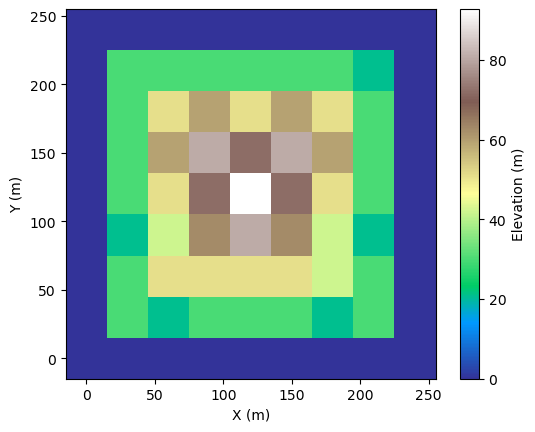

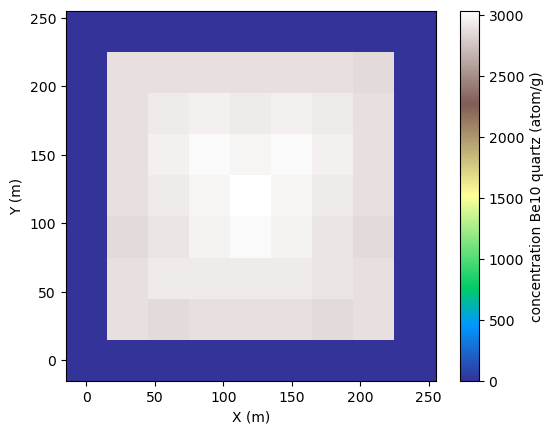

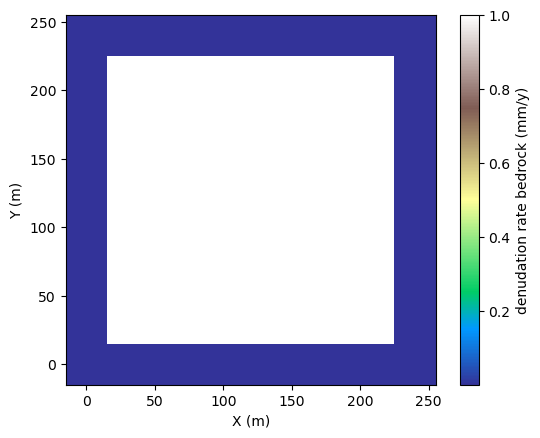

In [185]:
#drainage_plot(myGrid)
#plt.show()
myGrid.at_node["concentration_Be10_quartz_top_bedrock_atom_g"][myGrid.boundary_nodes] = 0

#imshow_grid(myGrid, myGrid.nodes, cmap ="terrain",
#                grid_units=("m", "m"), var_name="Node ids", show_elements=show_elements) #, show_elements=True)
#plt.show()
#graph.plot_graph(myGrid, at="node")

imshow_grid(myGrid, 'topographic__elevation', cmap ="terrain",
                grid_units=("m", "m"), var_name="Elevation (m)", show_elements=show_elements,)
                #limits=(0, 10)) #, show_elements=True)
plt.show()
imshow_grid(myGrid, 'concentration_Be10_quartz_top_bedrock_atom_g', cmap ="terrain",
                grid_units=("m", "m"), var_name="concentration Be10 quartz (atom/g)", show_elements=show_elements) #, show_elements=True)
plt.show()
imshow_grid(myGrid, 'denudation_rate_bedrock_mm_y', cmap ="terrain",
                grid_units=("m", "m"), var_name="denudation rate bedrock (mm/y)", show_elements=show_elements) #, show_elements=True)
plt.show()
#print(myGrid.at_node["concentration_Be10_quartz_top_bedrock_atom_g"])
#print(myGrid.at_node["denudation_rate_bedrock_mm_y"])
#print(myGrid.perimeter_nodes)

Text(0, 0.5, 'Mean Be10 concentration [log atom/g]')

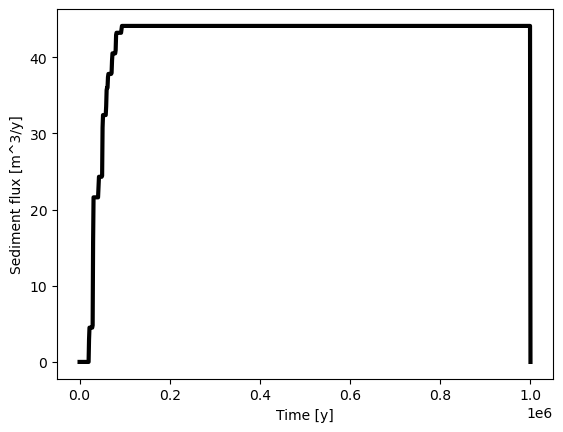

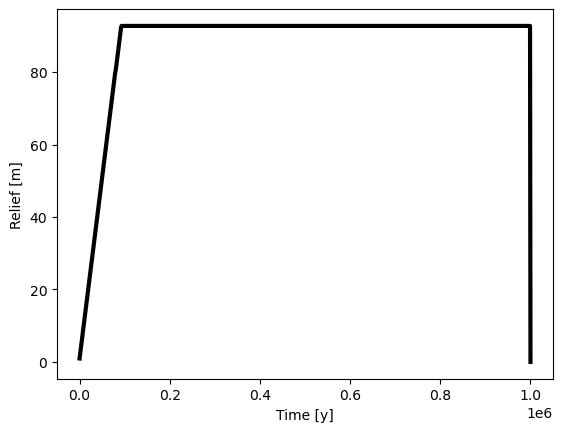

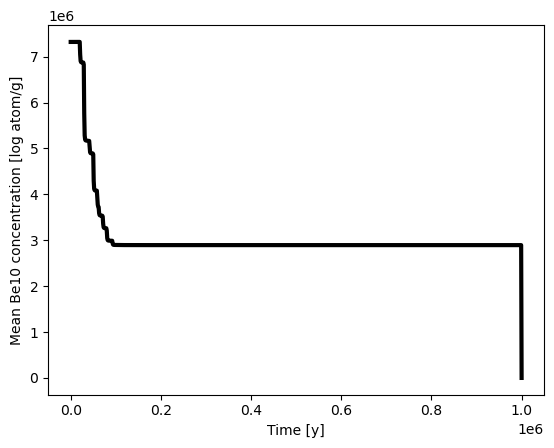

In [186]:
"""plt.figure()
# Instantiate subplot
sedfluxplot = plt.subplot()
# Plot data
sedfluxplot.plot(dt * np.arange(n_dt), sediment_flux_over_time, color="k", linewidth=3.0)

# Add axis labels
sedfluxplot.set_xlabel("Time [y]")
sedfluxplot.set_ylabel(r"Sediment flux [m$^3$/y]")
plt.show()"""

plt.figure()
plt.plot(dt * np.arange(n_dt + 1), sediment_flux_over_time, color="k", linewidth=3.0)
plt.xlabel("Time [y]")
plt.ylabel("Sediment flux [m^3/y]")

plt.figure()
plt.plot(dt * np.arange(n_dt + 1), relief_over_time, color="k", linewidth=3.0)
plt.xlabel("Time [y]")
plt.ylabel("Relief [m]")

plt.figure()
plt.plot(dt * np.arange(n_dt + 1), cosmogenic_concentration_over_time, color="k", linewidth=3.0)
plt.xlabel("Time [y]")
plt.ylabel("Mean Be10 concentration [log atom/g]") # TODO: prevent log?
#plt.yscale("log")
#plt.ylim([0, 5.e6])

Relief and Sedimentograph
relief is difference between lowest (here always zero) and highest

***(b)*** I want to change some default values that will be used for grid fields. To do this, edit the config files.

***(c)*** The grid has already some fields defined at nodes or if not, I want to define the field values at the node level. In that case, the component will override the config files and take the values of the grid fields.

### 1.2. Instantiate the Cosmogenic Production Scaler and first run.
The Cosmogenic Production Scaler yields local scaling factors associated with the nodes of the grid, computing following scaling models (See Cosmogenic scaling landlab.ipynb notebook).

We also run a first time the Scaler, because the Cosmogenic Producer preparation for first run needs scaling to calculate steady-state concentrations (CLARIFY).

### 1.3. Instantiate and run the Bedrock Cosmogenic Producer.
The Bedrock Cosmogenic Producer takes into account a specific nuclide, and will work as a function of selected production pathways and a production model (necessary for muons).

### 1.4. First run of the Bedrock Cosmogenic Producer.

Visualization of updated top bedrock concentrations

### 1.5. Following runs of the Bedrock Cosmogenic Producer.
When elevation does not vary a lot over the period of simulation, we can avoid running again the cosmogenic production scaler.

#### Equations
**(a) For neutron pathway.**

in Lal, 1991.

For a flat geometry target exposed with its surface horizontally, the production rate of a radionuclide, P (atoms/g) varies with depth, z (cm): 

$ P(z) = P(0)\ e^{-\rho z/\Lambda} \quad (2) $

$ P(z) = P(0)\,e^{-\mu z} \quad (2') $

where $\rho$ is the mean density of the target rock (g/cm -3) and $\Lambda$ is the absorption mean free path for nuclear interacting particles in the target (g/cm^2) of density $\rho$ (g/cm^3). P(0) is the production rate of the radionuclide at the target surface. In equation (2'), the symbol $\mu$ is defined as the absorption coefficient (cm^-1) in the target: $\mu=\rho/\Lambda$. 

The number of atoms of the radionuclide within the rock at any depth, z, N(z,t) is given by the differential equation: 

$\frac{\partial U(z,t)}{\partial t} = -N(z,t)\ \Lambda + P(z,t)  \quad (3)$

with $ P(z,t) = P(0,t)\,e^{-\mu z(t)} \quad (4) $ 

The erosion rate $\epsilon(t)$, defines the values of z(t) according to the equation: 
$x(t) = \int_{0}^{1}\epsilon(t)dt + const$. 

If $\epsilon(t) = const = \epsilon$ and $P(z, t) = P(z)$ does not vary with time,
then we obtain from (3) the equation:

$N(x,t) = N(x,0) e^{-\lambda t} + \frac{P(0)}{\lambda + \mu\epsilon} \ e^{-\mu z}(1 - e^{-(\lambda + \mu\epsilon)t}) \quad (6)$

where N(z,0) is the initial number of atoms/g in the rock surface now at depth z.

$\frac{P(0)}{\lambda + \mu\epsilon}$

- simplest: grid with production rate and concentrations
- burial under thick cover/production
